## Preamble

To perfectly replicate the results, it is best to reset Kernel and run all Cells. The simulation results may take up to 30 minutes to run depending on your device.

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from numpy.random import Generator

## Data Generating Process (DGP)

The DGP is based on approximate factor model by Alessi et al. (2008) with extension to account for the proportionality between the signals in $X$ and the signals in $\beta_*$.

In [2]:
def generate_X(n, p, r, random_state=None):
    rng = random_state if isinstance(random_state, Generator) else np.random.default_rng(random_state)
    
    theta = r
    F = rng.standard_normal((p, r))
    Lambda = rng.standard_normal((n, r))
    E = rng.standard_normal((n, p))
    
    return Lambda @ F.T + np.sqrt(theta) * E

def generate_Y(X, beta_star, random_state=None):
    rng = random_state if isinstance(random_state, Generator) else np.random.default_rng(random_state)
    
    eta = rng.standard_normal(X.shape[0])
    return X @ beta_star + eta

## Random projection methods

In order, GRP, SRP and DDRP.

In [3]:
def gaussian(p, k, random_state=None):
    rng = random_state if isinstance(random_state, Generator) else np.random.default_rng(random_state)
    
    return rng.standard_normal((k, p)) / np.sqrt(k)

def sparse(p, k, s=3, random_state=None):
    rng = random_state if isinstance(random_state, Generator) else np.random.default_rng(random_state)
    
    prob = 1.0 / s
    choices = [np.sqrt(s), 0, -np.sqrt(s)]
    probs = [prob/2, 1-prob, prob/2]
    
    return rng.choice(choices, size=(k, p), p=probs)

def ddrp(X, k, random_state=None):
    rng = random_state if isinstance(random_state, Generator) else np.random.default_rng(random_state)
    
    n, p = X.shape
    W = rng.standard_normal((k, n)) / np.sqrt(k)
    
    return W @ X

## Simulation

In [4]:
def mean_squared_prediction_error(X, Y, Phi_func, p, k, n_ensemble=100, random_state=None):
    rng = random_state if isinstance(random_state, np.random.Generator) else np.random.default_rng(random_state)
    
    n = X.shape[0]
    
    preds = np.zeros((n_ensemble, n))
    
    for i in range(n_ensemble):
        Phi = Phi_func(p, k, random_state=rng)
        
        X_tilde = X @ Phi.T
        
        model = LinearRegression(fit_intercept=True)
        model.fit(X_tilde, Y)
        
        preds[i, :] = model.predict(X_tilde)
    
    y_pred_average = preds.mean(axis=0)
    
    mspe = np.mean((Y - y_pred_average) ** 2)
    return mspe

def simulation(r_values, n_p_pairs, k_values, theta, n_reps=100, n_ensemble=100, random_state=None):
    rng = random_state if isinstance(random_state, np.random.Generator) else np.random.default_rng(random_state)
    
    results = []
    
    for n, p in n_p_pairs:
        for r in r_values:
            beta_star = np.ones(p) / np.sqrt((r + theta) * p)
            
            for _ in range(n_reps):
                X = generate_X(n, p, r, random_state=rng)
                Y = generate_Y(X, beta_star, random_state=rng)
                
                for method_name, rp in [
                    ('Gaussian', gaussian),
                    ('Sparse', sparse),
                    ('DDRP', lambda p_dim, k_dim, random_state=None: ddrp(X, k_dim, random_state))
                ]:
                    for k in k_values:
                        mspe = mean_squared_prediction_error(X, Y, Phi_func=rp, p=p, k=k, n_ensemble=n_ensemble, random_state=rng)
                        
                        results.append({'n': n, 'p': p, 'r': r, 'k': k, 'method': method_name, 'mspe': mspe})
    df = pd.DataFrame(results)
    summary = df.groupby(['n', 'p', 'r', 'k', 'method'])['mspe'].agg(mean_mspe='mean', sd_mspe='std',
                                                                    ci_lower=lambda x: np.percentile(x, 2.5),
                                                                    ci_upper=lambda x: np.percentile(x, 97.5)
                                                                    ).reset_index()
    
    return df, summary

## Results from all simulations: k = 3, 8, 15, 30

In [5]:
if __name__ == '__main__':
    r_values = [1, 3, 5, 8, 10, 15]
    n_p_pairs = [(100, 110), (100, 200), (100, 1000)]
    k_values = [3, 8, 15, 30]
    theta = 1.0
    
    t_start = time.perf_counter()
    
    df_results, df_summary = simulation(r_values, n_p_pairs, k_values, theta, n_reps=100, n_ensemble=100, random_state=12)
    
    t_end = time.perf_counter()
    elapsed = t_end - t_start
    
    print(f'Simulation completed in {elapsed:.2f} seconds')
    print(df_summary)

Simulation completed in 1600.12 seconds
       n     p   r   k    method  mean_mspe   sd_mspe  ci_lower  ci_upper
0    100   110   1   3      DDRP   1.359882  0.188337  1.041847  1.694299
1    100   110   1   3  Gaussian   1.414529  0.209840  1.053780  1.843369
2    100   110   1   3    Sparse   1.415887  0.213072  1.059907  1.819827
3    100   110   1   8      DDRP   1.183290  0.161184  0.917857  1.478226
4    100   110   1   8  Gaussian   1.203563  0.165710  0.936619  1.515206
..   ...   ...  ..  ..       ...        ...       ...       ...       ...
211  100  1000  15  15  Gaussian   1.664964  0.215030  1.227816  2.054000
212  100  1000  15  15    Sparse   1.661227  0.217765  1.225188  2.030577
213  100  1000  15  30      DDRP   1.053254  0.162142  0.735536  1.325270
214  100  1000  15  30  Gaussian   1.061264  0.147247  0.763485  1.321853
215  100  1000  15  30    Sparse   1.056477  0.143725  0.775210  1.301056

[216 rows x 9 columns]


### Saving results as csv

Code for ordering results and save as csv file:

In [6]:
df_final = df_summary.pivot(index=['p', 'k', 'r'], columns='method', values=['mean_mspe', 'sd_mspe'])

df_final.columns = [f"{method}_{'MSPE' if stat == 'mean_mspe' else 'SD'}" for stat, method in df_final.columns]

df_final = (df_final.reset_index().sort_values(['p', 'k', 'r']))

ordered_methods = ['Gaussian', 'Sparse', 'DDRP']
cols = ['p', 'k', 'r'] + [f'{m}_{suffix}' for m in ordered_methods for suffix in ['MSPE', 'SD']]

df_finals = df_final[cols]

desktop = os.path.join(os.path.expanduser('~'), 'Desktop')
os.makedirs(desktop, exist_ok=True)
outpath = os.path.join(desktop, 'df_finals.csv')
df_finals.to_csv(outpath, index=False)

print(f'Saved simulation results to {outpath}')

Saved simulation results to /Users/linh/Desktop/df_finals.csv


### Graphing MSPE of all methods

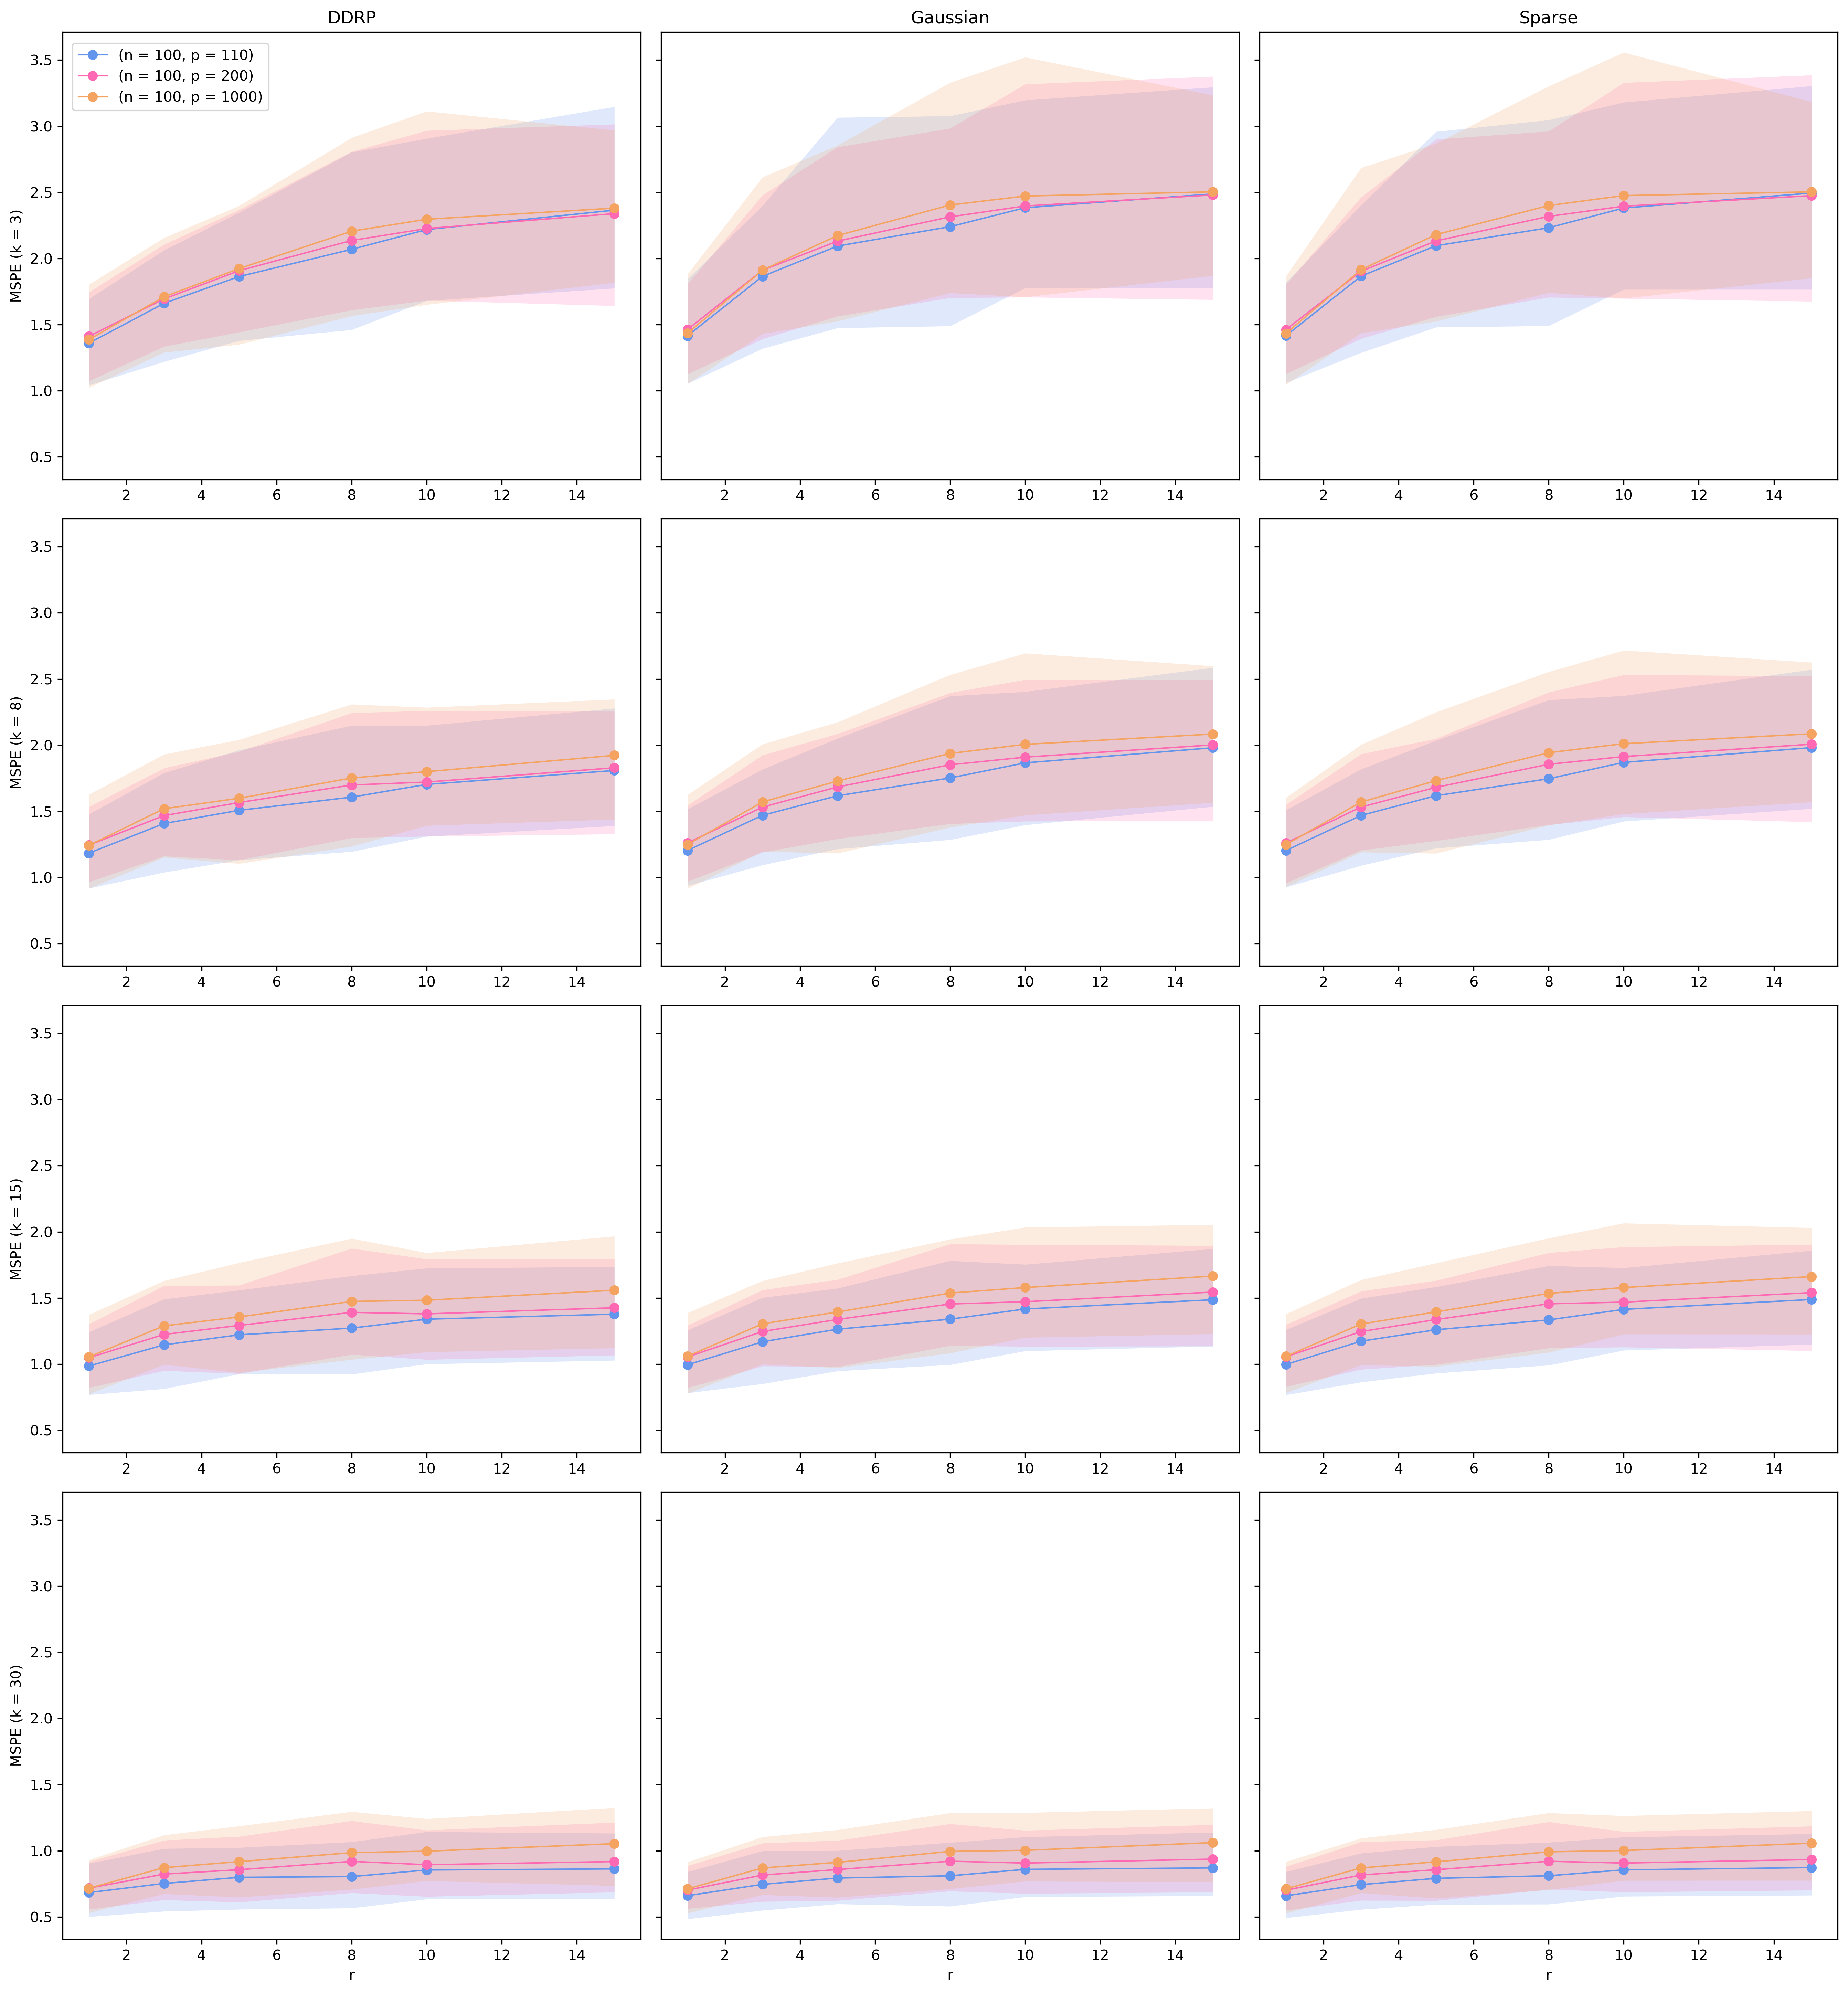

In [7]:
methods = df_summary['method'].unique()
k_values = sorted(df_summary['k'].unique())
n_p_pairs = [(100,110), (100,200), (100,1000)]
colors = ['cornflowerblue', 'hotpink', 'sandybrown']

fig, axes = plt.subplots(len(k_values), len(methods), figsize=(6 * len(methods), 5 * len(k_values)), dpi=300,
                        sharex=False, sharey=True)

if axes.ndim == 1:
    axes = axes.reshape(len(k_values), len(methods))

for i, k0 in enumerate(k_values):
    for j, method in enumerate(methods):
        ax = axes[i, j]
        sub = df_summary.query("k==@k0 and method==@method")
    
        for idx, (n0, p0) in enumerate(n_p_pairs):
            sp = sub.query("n==@n0 and p==@p0")
            x = sp['r']
            y = sp['mean_mspe']
            lo = sp['ci_lower']
            hi = sp['ci_upper']
            col = colors[idx]
        
            ax.plot(x, y, marker='o', linewidth=1, color=col, label=f'(n = {n0}, p = {p0})')
            ax.fill_between(x, lo, hi, color=col, alpha=0.2, linewidth=0)
        
        if i == 0:
            ax.set_title(method)
        if i == len(k_values) - 1:
            ax.set_xlabel('r')
        if j == 0:
            ax.set_ylabel(f'MSPE (k = {k0})')

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.038, 0.98), bbox_transform=fig.transFigure,
           frameon=True, fancybox=True)

fig.tight_layout(rect=[0,0.03,1,1])
desktop = os.path.join(os.path.expanduser('~'), 'Desktop')
outpath = os.path.join(desktop, 'mspe_compress_all_methods.png')
fig.savefig(outpath, dpi=300, bbox_inches='tight')

plt.show()

### Graphing relative improvement of SRP and DDRP relative to GRP: MSPE

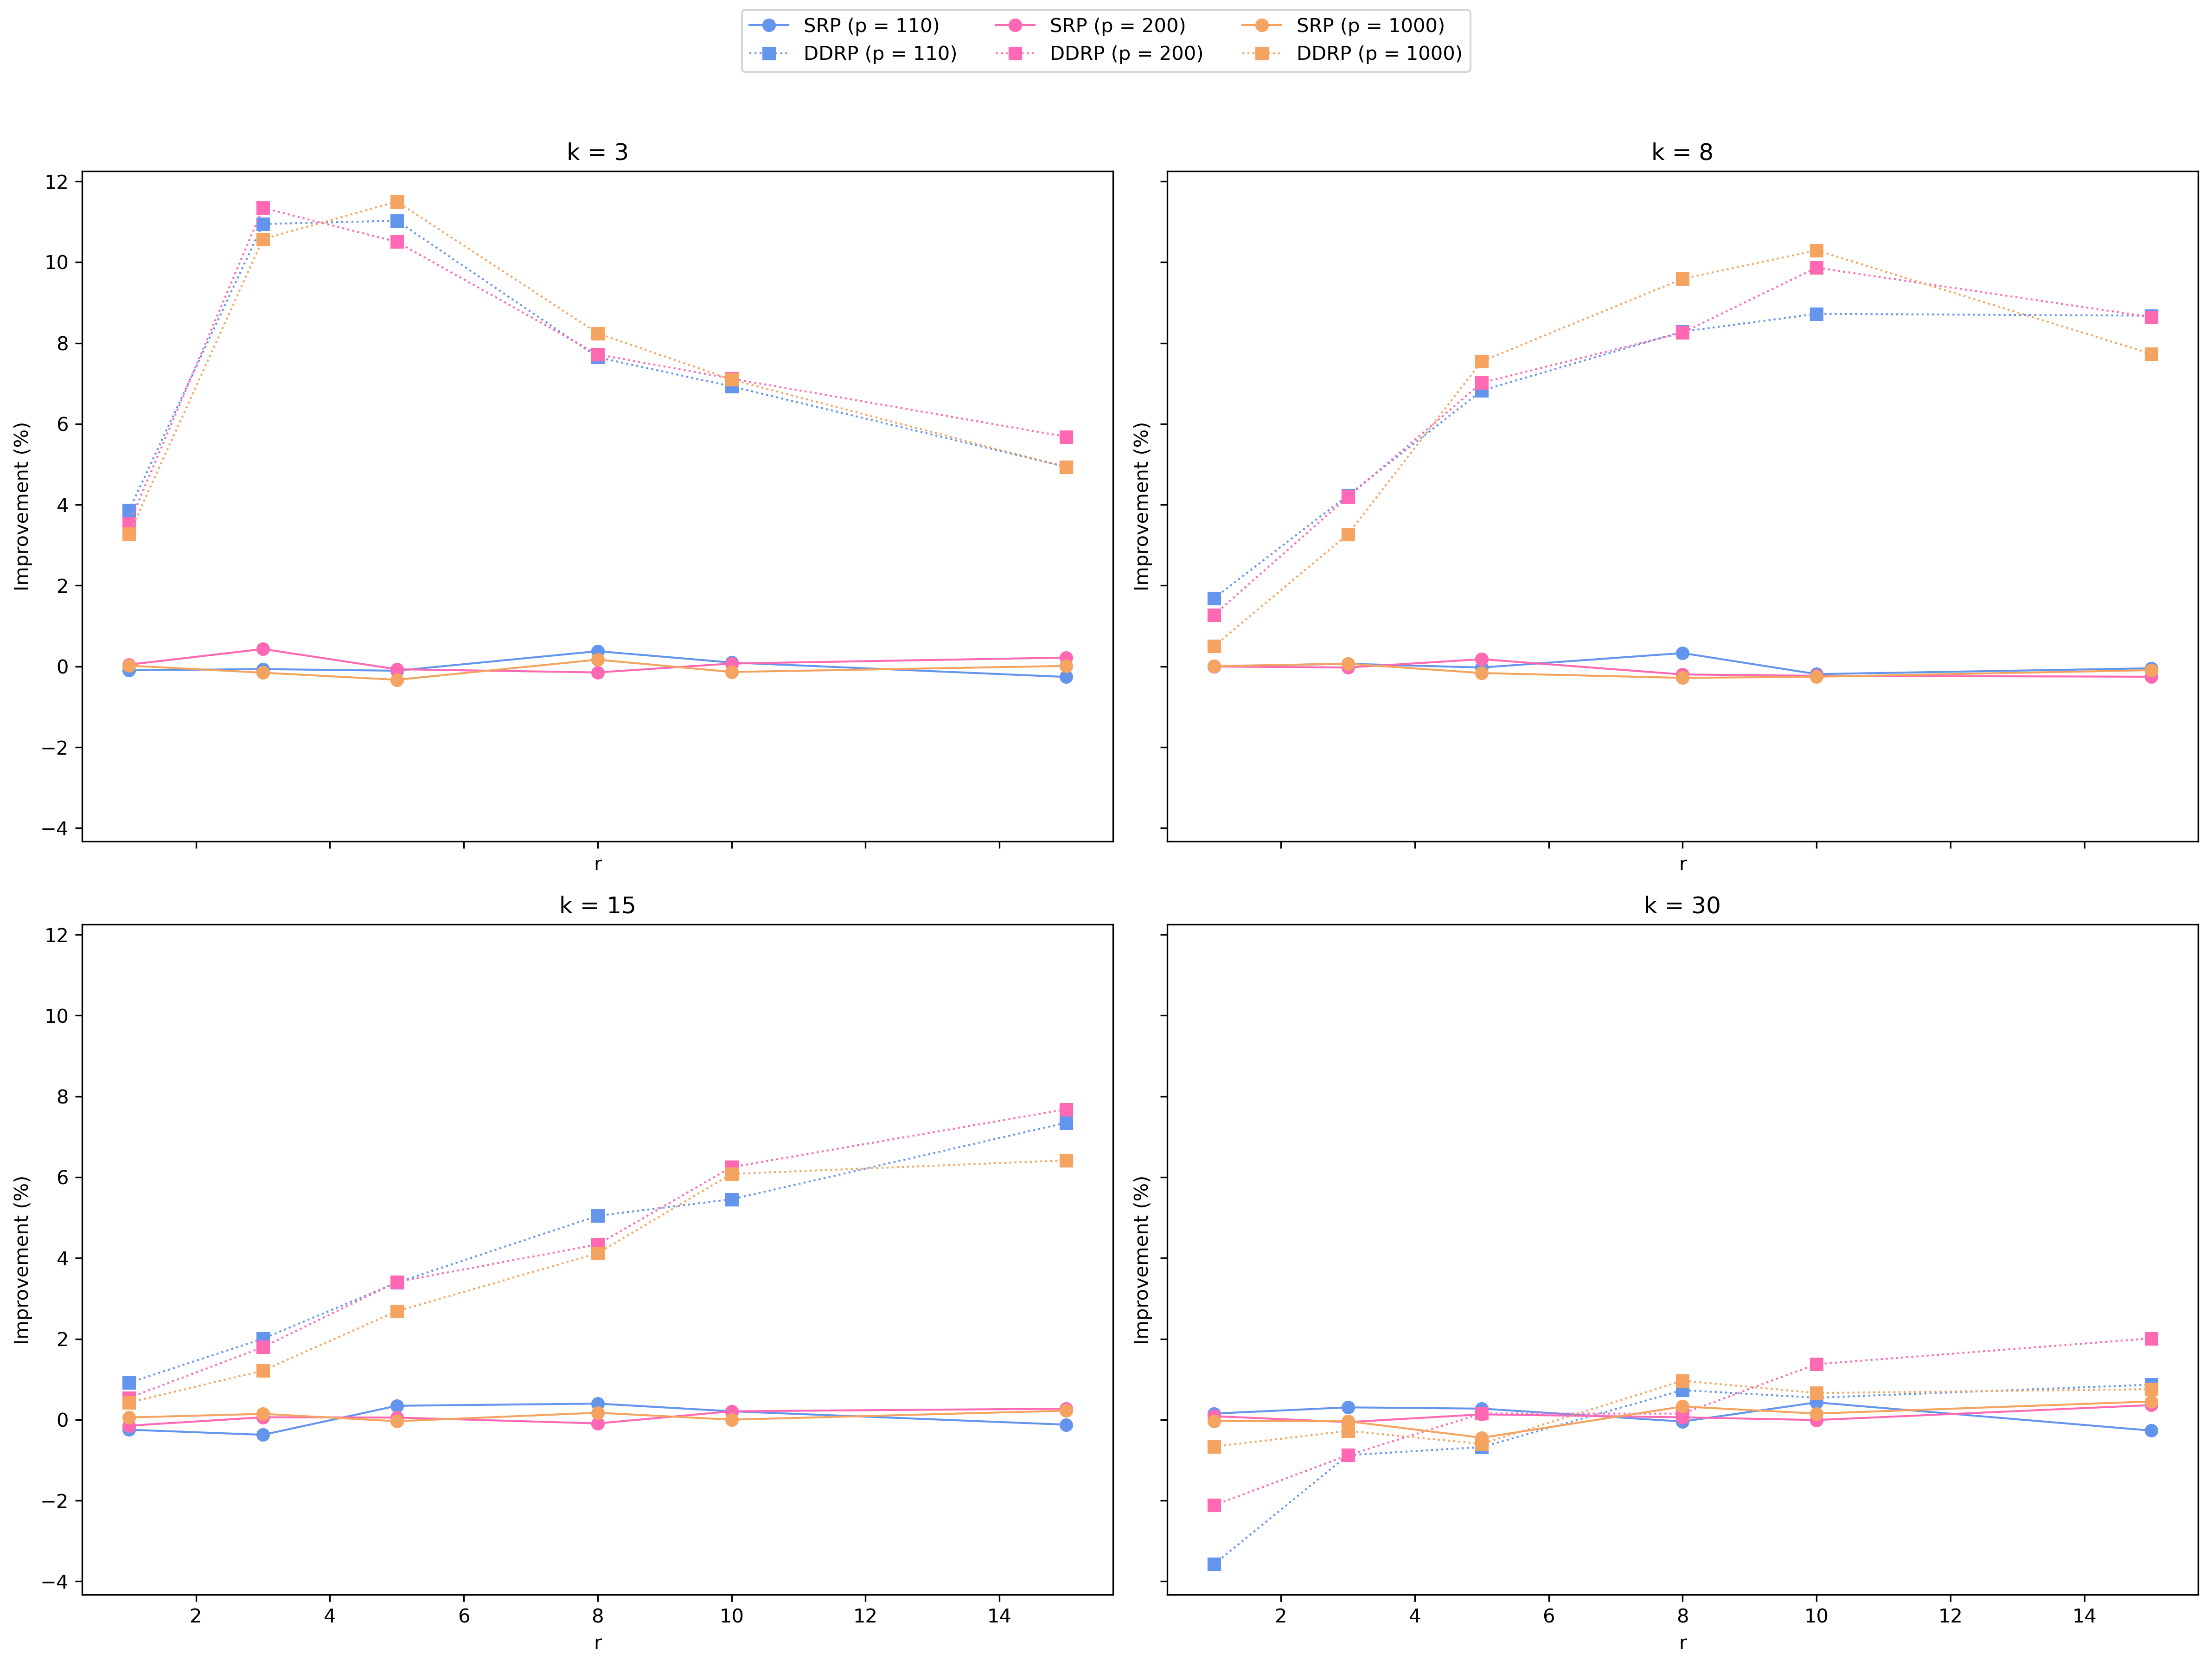

In [8]:
home = os.path.expanduser('~')
csv_path = os.path.join(home, 'Desktop', 'df_finals.csv')
df = pd.read_csv(csv_path)

# Calculate improvement in MSPE
df['gain_SRP'] = 100 * (df['Gaussian_MSPE'] - df['Sparse_MSPE']) / df['Gaussian_MSPE']
df['gain_DDRP'] = 100 * (df['Gaussian_MSPE'] - df['DDRP_MSPE']) / df['Gaussian_MSPE']

color_map = {110: 'cornflowerblue', 200: 'hotpink', 1000: 'sandybrown'}
linewidth_map = {110: 1, 200: 1, 1000: 1}

ks = sorted(df['k'].unique())
fig, axs = plt.subplots(2, 2, figsize=(16,12), dpi=300, sharex=True, sharey=True)
axs = axs.flatten()

for ax, k_val in zip(axs, ks):
    subf = df[df['k'] == k_val]
    for p_val in sorted(subf['p'].unique()):
        grp = subf[subf['p'] == p_val]
        color = color_map[p_val]
        lw = linewidth_map[p_val]
        
        ax.plot(grp['r'], grp['gain_SRP'], marker='o', linestyle='-', color=color, linewidth=lw,
                label=f'SRP (p = {p_val})')
        ax.plot(grp['r'], grp['gain_DDRP'], marker='s', linestyle=':', color=color, linewidth=lw,
               label=f'DDRP (p = {p_val})')
    
    ax.set_title(f'k = {k_val}')
    ax.set_xlabel('r')
    ax.set_ylabel('Improvement (%)')
    ax.grid(False)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, frameon=True)

fig.tight_layout(rect=[0,0,1,0.93])
desktop = os.path.join(os.path.expanduser('~'), 'Desktop')
outpath = os.path.join(desktop, 'mspe_improvement.png')
fig.savefig(outpath, dpi=300, bbox_inches='tight')

plt.show()

### Graphing relative improvement of SRP and DDRP relative to GRP: SD

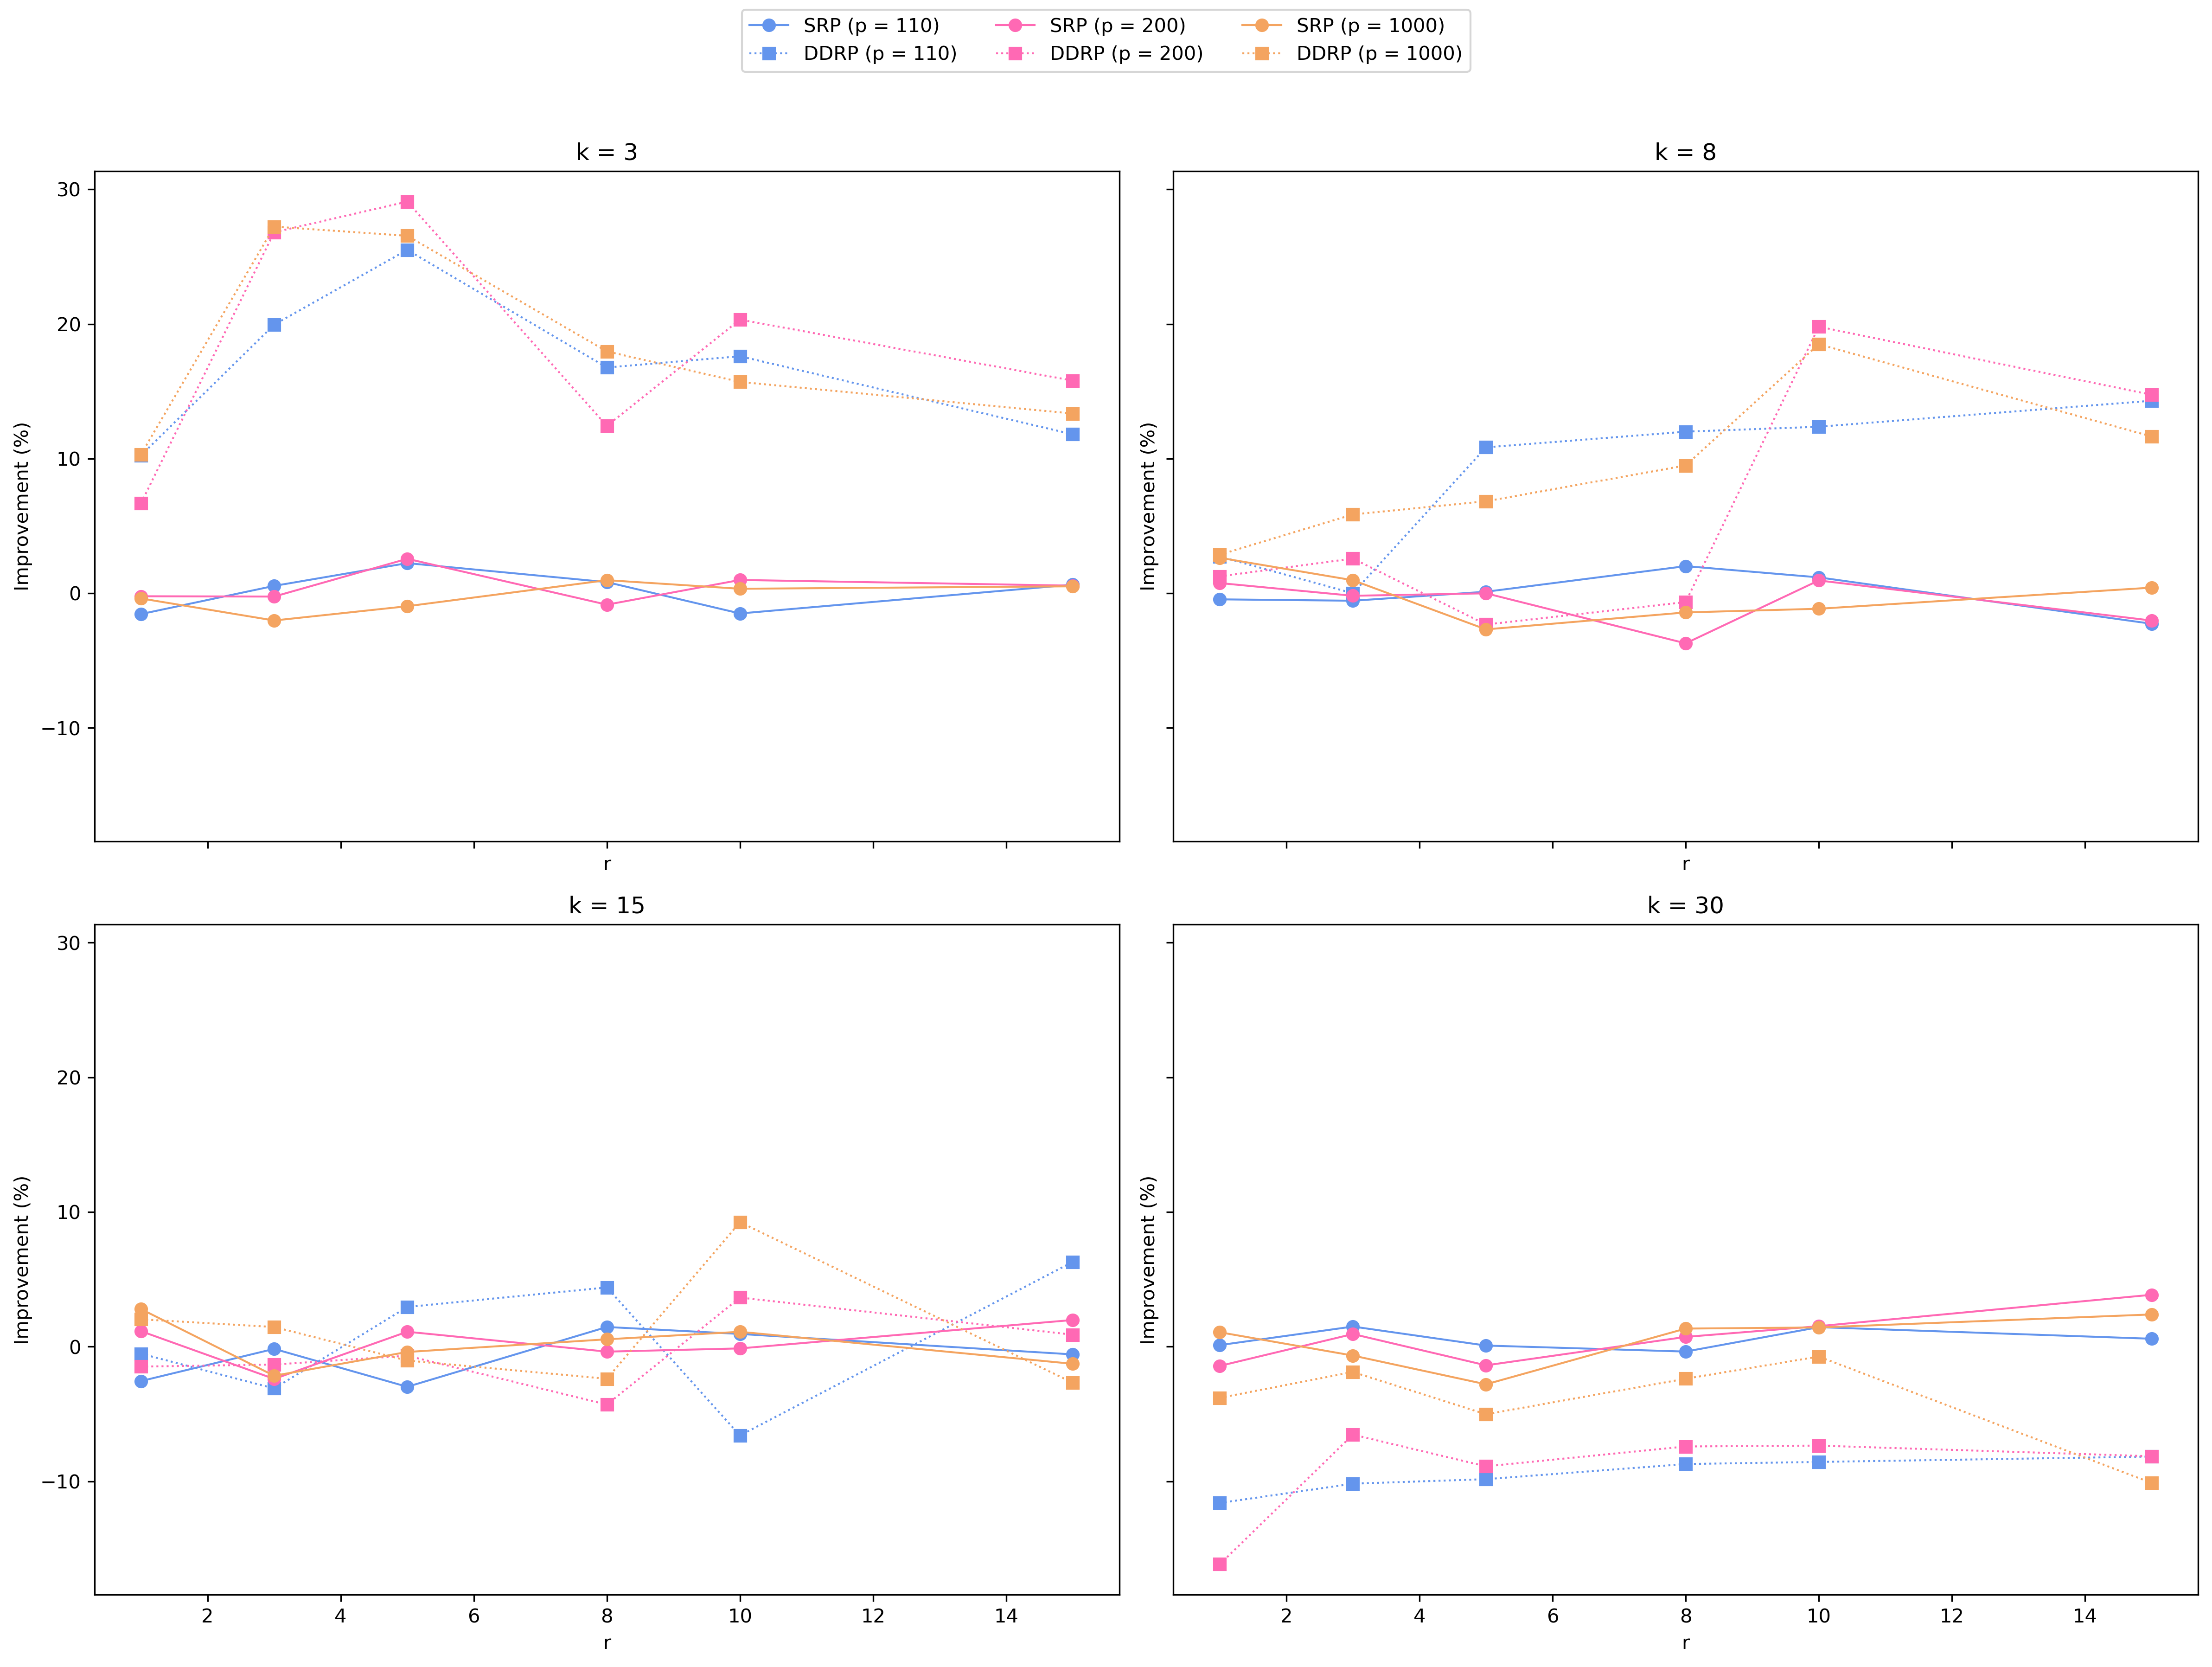

In [9]:
# Calculuate improvement in SD
df['sd_gain_SRP'] = 100 * (df['Gaussian_SD'] - df['Sparse_SD']) / df['Gaussian_SD']
df['sd_gain_DDRP'] = 100 * (df['Gaussian_SD'] - df['DDRP_SD']) / df['Gaussian_SD']

color_map = {110: 'cornflowerblue', 200: 'hotpink', 1000: 'sandybrown'}
linewidth_map = {110: 1, 200: 1, 1000: 1}

ks = sorted(df['k'].unique())
fig, axs = plt.subplots(2, 2, figsize=(16,12), dpi=300, sharex=True, sharey=True)
axs = axs.flatten()

for ax, k_val in zip(axs, ks):
    subf = df[df['k'] == k_val]
    for p_val in sorted(subf['p'].unique()):
        grp = subf[subf['p'] == p_val]
        color = color_map[p_val]
        lw = linewidth_map[p_val]
        
        ax.plot(grp['r'], grp['sd_gain_SRP'], marker='o', linestyle='-', color=color, linewidth=lw, label=f'SRP (p = {p_val})')
        
        ax.plot(grp['r'], grp['sd_gain_DDRP'], marker='s', linestyle=':', color=color, linewidth=lw, label=f'DDRP (p = {p_val})')
        
    
    ax.set_title(f'k = {k_val}')
    ax.set_xlabel('r')
    ax.set_ylabel('Improvement (%)')
    ax.grid(False)
    
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, frameon=True)

fig.tight_layout(rect=[0, 0, 1, 0.93])
desktop = os.path.join(os.path.expanduser('~'), 'Desktop')
outpath = os.path.join(desktop, 'sd_improvement.png')
fig.savefig(outpath, dpi=300, bbox_inches='tight')

plt.show()

### Graphing relative improvement across different p values

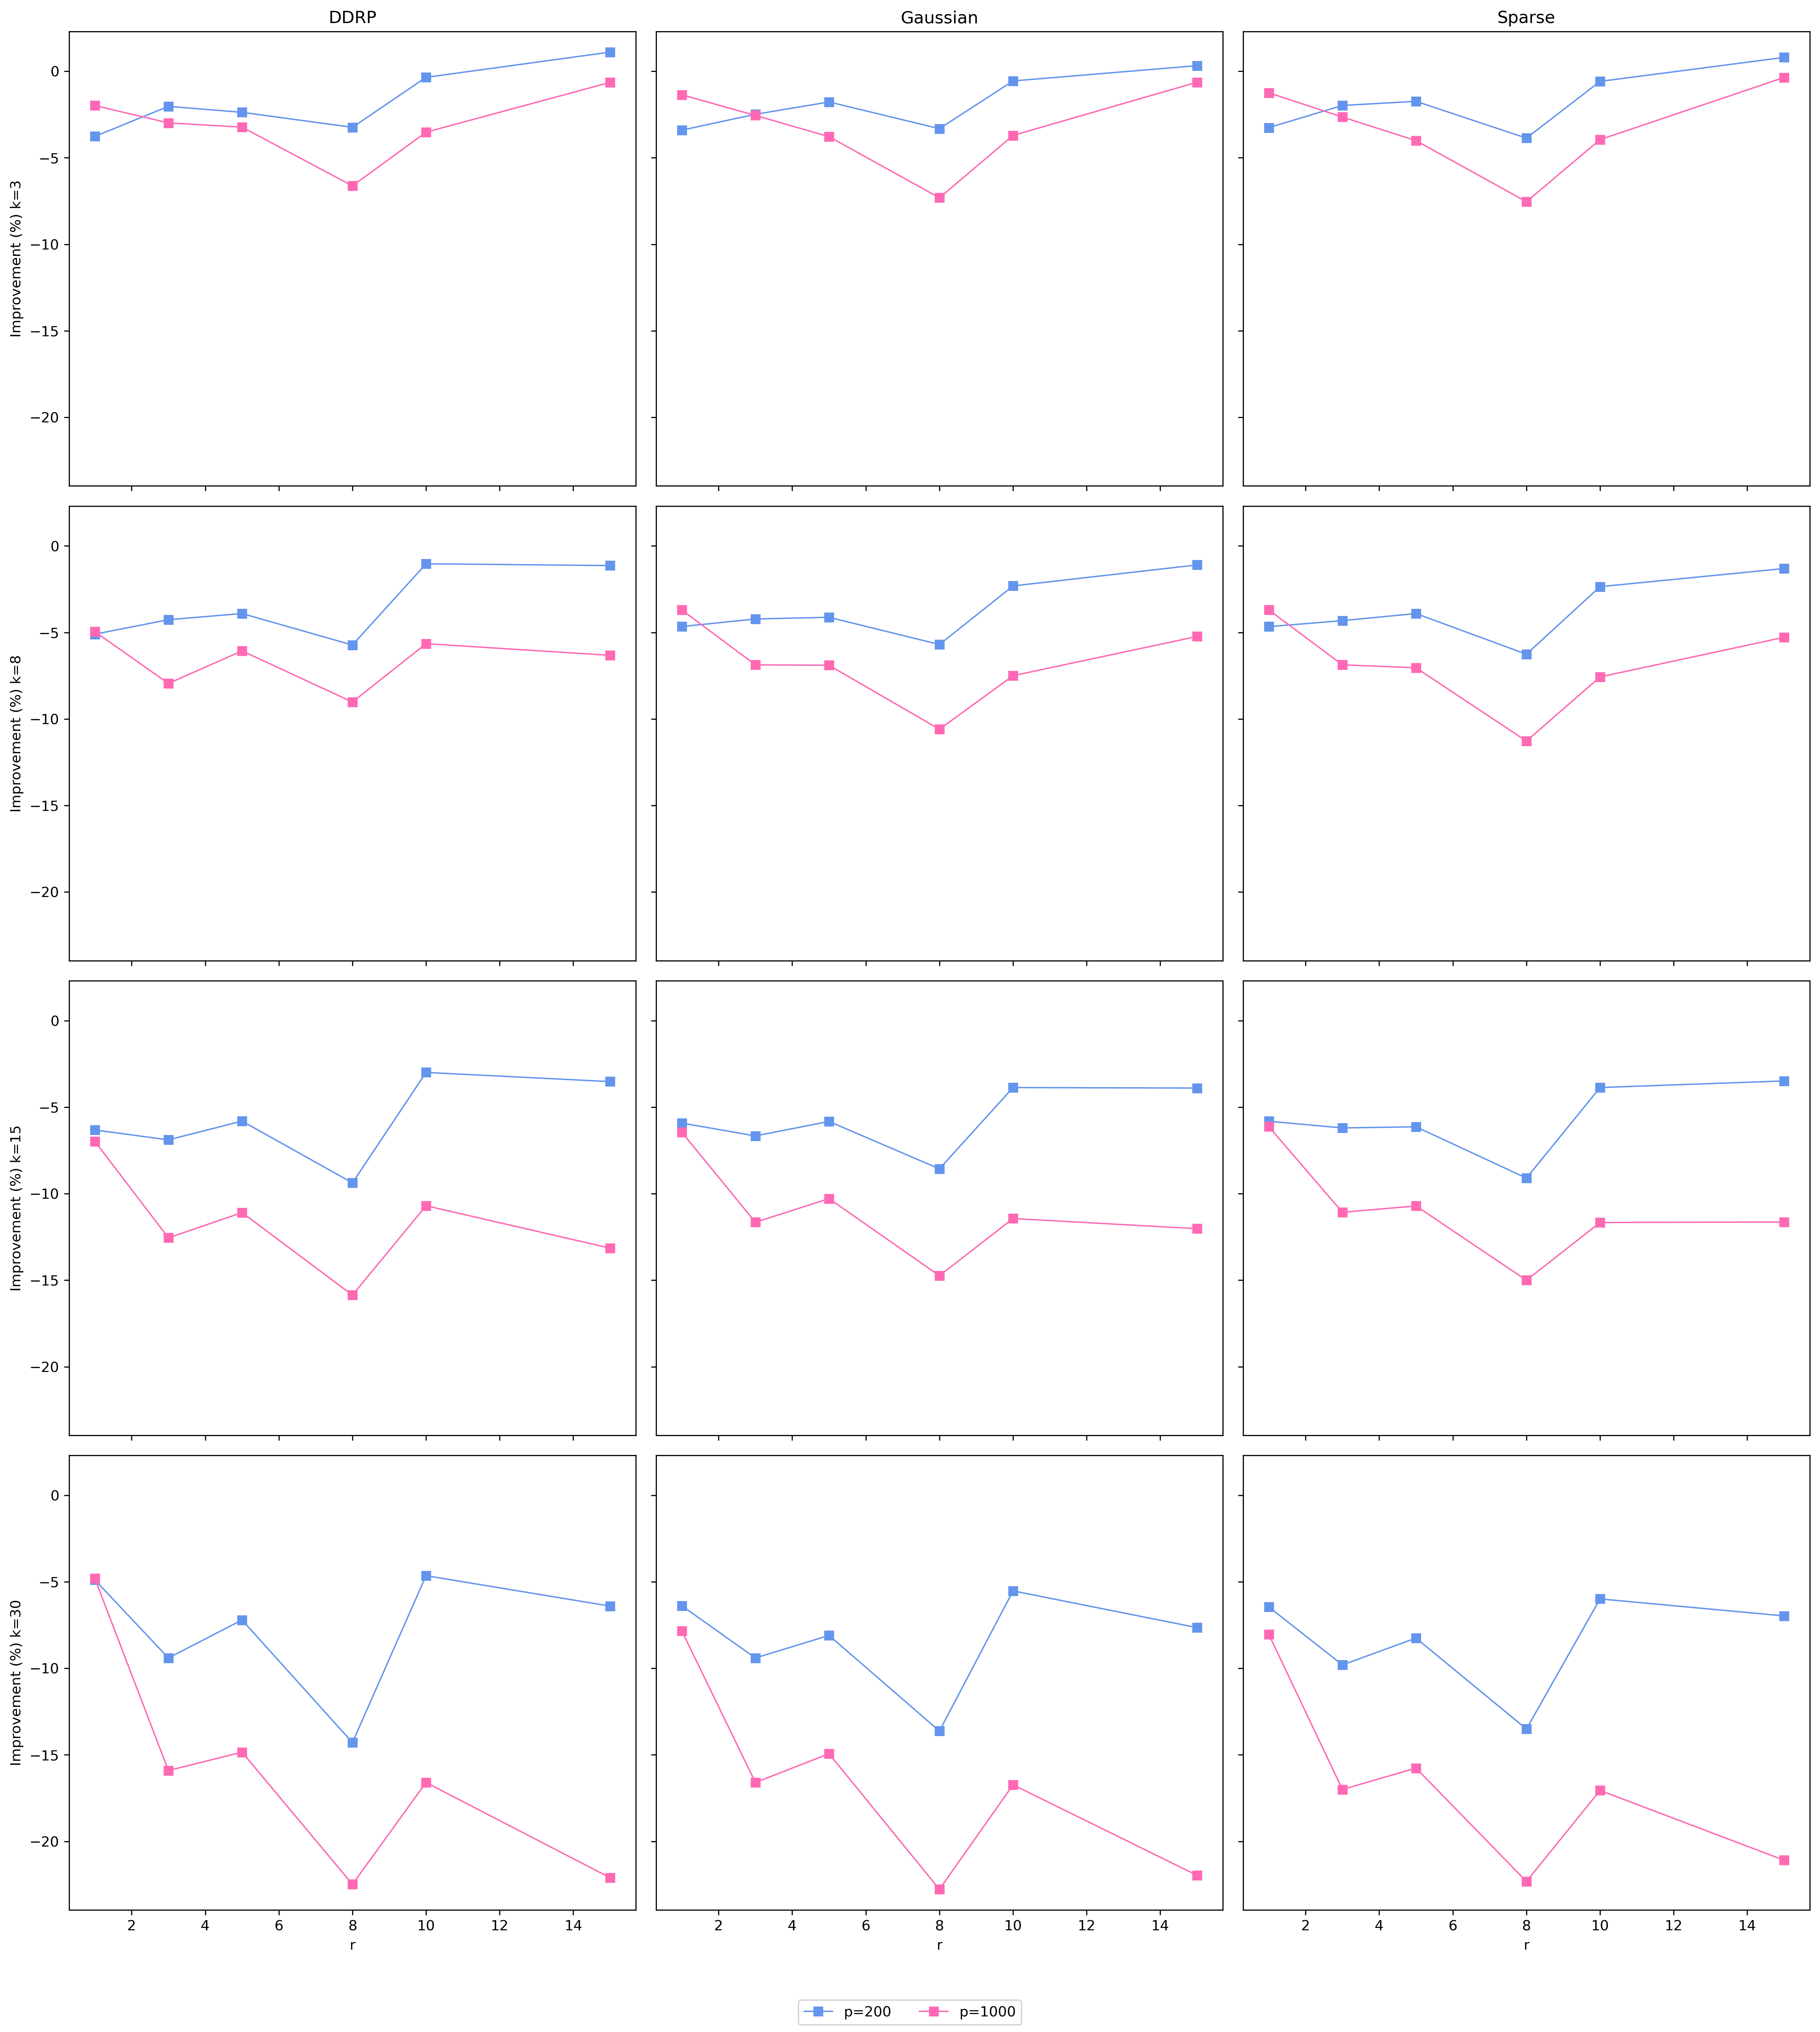

In [10]:
import matplotlib.pyplot as plt

baseline = (df_summary.query("p == 110").loc[:, ['method','k','r','mean_mspe']].rename(columns={'mean_mspe':'mspe_110'}))

df_pct = (df_summary.query("p != 110").merge(baseline, on=['method','k','r']))

df_pct['pct_improve'] = 100 * (df_pct['mspe_110'] - df_pct['mean_mspe']) / df_pct['mspe_110']

methods  = df_pct['method'].unique()
k_values = sorted(df_pct['k'].unique())
p_vals   = [200, 1000]
colors   = {200:'cornflowerblue', 1000:'hotpink'}

fig, axes = plt.subplots(len(k_values), len(methods), figsize=(6 * len(methods), 5 * len(k_values)), dpi=300,
                         sharex=True, sharey=True)
if axes.ndim == 1:
    axes = axes.reshape(len(k_values), len(methods))

for i, k0 in enumerate(k_values):
    for j, method in enumerate(methods):
        ax = axes[i, j]
        sub = df_pct.query("k==@k0 and method==@method")

        for p0 in p_vals:
            sp = sub[sub['p'] == p0]
            ax.plot(sp['r'], sp['pct_improve'], marker='s', linewidth=1, color=colors[p0], label=f"p={p0}")


        if i == len(k_values) - 1:
            ax.set_xlabel('r')
        if j == 0:
            ax.set_ylabel(f'Improvement (%) k={k0}')
        if i == 0:
            ax.set_title(method)

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(p_vals), frameon=True, fancybox=True)

fig.tight_layout(rect=[0, 0.03, 1, 1])
desktop = os.path.join(os.path.expanduser('~'), 'Desktop')
outpath = os.path.join(desktop, 'p_improvement.png')
fig.savefig(outpath, dpi=300, bbox_inches='tight')

plt.show()